In [1]:
%cd ..

/home/jupyter-tim/ba-tim


In [2]:
from drlqap.taskgenerators import generators, RandomWeightsTaskGenerator, RandomMatricesTaskGenerator, LinearTaskGenerator
from collections import defaultdict

In [347]:
# Generate new problems
sizes = [4,6,8,12,16,24,32,48,64,96,128,192,256]
count = 20
problems = {
    i: [RandomWeightsTaskGenerator(i).sample() for _ in range(count)] for i in sizes
}

In [348]:
# Clear results
results = {}

In [665]:
import scipy.optimize
from drlqap.simplesolver import solve_qap_backtracking, solve_qap_maxgreedy, solve_qap_faq, solve_random, solve_partial_random, solve_best_of_k
from drlqap.gurobi import solve_qap_gurobi
import numpy as np
from drlqap.qap import QAP
from drlqap.evaltools import load_checkpoints
from pathlib import Path
import random
import matplotlib
import matplotlib.pyplot as plt
import time
import importlib
import torch
import math

In [666]:
def evaluate(solver, problem, samples):
    if type(problem) == str:
        generator = generators[problem]
    else:
        generator = problem
    qaps = [generator.sample() for i in range(samples)]
    return evaluate_set(solver, qaps)
    
def evaluate_set(solver, problems):
    with torch.no_grad():
        start = time.perf_counter()
        values = []
        correct = 0
        for qap in problems:
            v_solver, assignment = solver(qap)
            v = qap.compute_value(assignment)
            if not np.isclose(v, v_solver):
                print (f"solver outputs incorrect value (got {v_solver}, actual {v})")
            values.append(v)
        end = time.perf_counter()
        mean = np.mean(values)
        variance = np.var(values)
        return mean, variance, (end - start) / len(problems)

In [667]:
def evaluate_full_and_store(solver_name, force=False, max_size=math.inf):
    if solver_name not in results or force:
        solver = solvers[solver_name]
        means = []
        variances = []
        times = []
        for n in sizes:
            if n < max_size:
                m, v, t = evaluate_set(solver, problems[n])
                means.append(m)
                variances.append(v)
                times.append(t)
                print(f"{solver_name} on n={n}: mean={m:.3f}, var={v:.3f}, t={t:.3f}")
                results[solver_name] = {
                    "means": np.array(means),
                    "vars": np.array(variances),
                    "times": np.array(times)
                }

In [671]:
solvers = {
    'faq': solve_qap_faq,
    'a2c_md': load_checkpoints(Path('runs/a2c_ms100x_mediumrandoms/lr4e-5_s3'))[-1].solve,
    'random': solve_random,
    'max_greedy': solve_qap_maxgreedy,
    'dqn_sm': load_checkpoints(Path('runs/dqn_dense_ms_ec_eps0_smallrandoms/lr5e-4_s1'))[-1].solve,
    'dqn_md': load_checkpoints(Path('runs/dqn_dense_ms_ec_eps0_mediumrandoms/lr5e-4_s1'))[-1].solve,
    'rf': load_checkpoints(Path('runs/reinforce_ms100x_smallrandoms/lr1e-4_s4/'))[-1].solve,
    'last7opt': lambda qap: solve_partial_random(qap, 7),
    'last8opt': lambda qap: solve_partial_random(qap, 8),
    'rand1k': lambda qap: solve_best_of_k(qap, 1000, solve_random),
    'rand5k': lambda qap: solve_best_of_k(qap, 5000, solve_random),
    'rand10k': lambda qap: solve_best_of_k(qap, 10000, solve_random),
    'a2c_sm': load_checkpoints(Path('runs/a2c_ms100x_smallrandoms/lr4e-5_s2'))[-1].solve,
    'mcq_sm': load_checkpoints(Path('runs/mcq_eps0_smallrandoms/lr3e-4_s2'))[-1].solve,
    'dqn_md_e': load_checkpoints(Path('runs/dqn_dense_ms_ec_mediumrandoms/lr5e-4_s1'))[-1].solve,
    #'gurobi_5s': lambda qap: solve_qap_gurobi(qap, time_limit=5),
}

solvers['rf_top5'] = lambda qap: solve_best_of_k(qap, 5, solvers['rf'])
solvers['rf_top20'] = lambda qap: solve_best_of_k(qap, 20, solvers['rf'])
solvers['a2c_top5'] = lambda qap: solve_best_of_k(qap, 5, solvers['a2c_sm'])
solvers['a2c_top20'] = lambda qap: solve_best_of_k(qap, 20, solvers['a2c_sm'])


runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_0.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_1000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_2000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_3000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_4000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_5000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_6000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_7000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_8000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_9000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_10000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_11000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_12000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_13000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_14000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_s3/checkpoint_15000.pth
runs/a2c_ms100x_mediumrandoms/lr4e-5_

runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_7000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_8000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_9000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_10000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_11000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_12000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_13000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_14000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_15000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_16000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_17000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_18000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_19000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_20000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_21000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_22000.pth
runs/mcq_eps0_smallrandoms/lr3e-4_s2/checkpoint_23000.pth
runs/mcq_eps0_sma

In [353]:
evaluate_full_and_store("random")

random on n=4: mean=3.129, var=1.298, t=0.000
random on n=6: mean=7.608, var=2.450, t=0.000
random on n=8: mean=14.859, var=4.927, t=0.000
random on n=12: mean=34.117, var=7.830, t=0.000
random on n=16: mean=59.935, var=16.830, t=0.000
random on n=24: mean=136.650, var=62.264, t=0.000
random on n=32: mean=245.018, var=55.804, t=0.000
random on n=48: mean=556.268, var=148.084, t=0.000
random on n=64: mean=1003.681, var=511.487, t=0.005
random on n=96: mean=2274.438, var=733.134, t=0.001
random on n=128: mean=4066.802, var=1682.740, t=0.001
random on n=192: mean=9173.892, var=3934.741, t=0.001
random on n=256: mean=16317.705, var=3634.725, t=0.001


In [354]:
evaluate_full_and_store("faq")

faq on n=4: mean=2.914, var=1.374, t=0.002
faq on n=6: mean=6.337, var=3.416, t=0.003
faq on n=8: mean=11.906, var=4.938, t=0.003
faq on n=12: mean=28.777, var=5.433, t=0.004
faq on n=16: mean=49.089, var=12.683, t=0.004
faq on n=24: mean=115.458, var=54.360, t=0.007
faq on n=32: mean=209.625, var=48.460, t=0.008
faq on n=48: mean=486.937, var=172.543, t=0.015
faq on n=64: mean=884.367, var=494.583, t=0.030
faq on n=96: mean=2034.699, var=507.897, t=0.063
faq on n=128: mean=3678.616, var=1694.991, t=0.106
faq on n=192: mean=8445.224, var=2086.125, t=0.260
faq on n=256: mean=15135.755, var=2662.751, t=0.493


In [680]:
evaluate_full_and_store("max_greedy")

max_greedy on n=4: mean=2.744, var=1.218, t=0.002
max_greedy on n=6: mean=6.590, var=3.068, t=0.002
max_greedy on n=8: mean=12.880, var=5.032, t=0.003
max_greedy on n=12: mean=31.424, var=6.098, t=0.004
max_greedy on n=16: mean=54.708, var=13.355, t=0.006
max_greedy on n=24: mean=128.513, var=53.497, t=0.008
max_greedy on n=32: mean=236.255, var=37.908, t=0.011
max_greedy on n=48: mean=543.132, var=117.404, t=0.017
max_greedy on n=64: mean=976.862, var=514.467, t=0.028
max_greedy on n=96: mean=2223.798, var=782.473, t=0.049
max_greedy on n=128: mean=3999.111, var=2163.624, t=0.088
max_greedy on n=192: mean=9091.696, var=2477.896, t=0.176
max_greedy on n=256: mean=16171.606, var=5642.444, t=0.308


In [355]:
evaluate_full_and_store("a2c_md")
evaluate_full_and_store("a2c_sm")
evaluate_full_and_store("rf")

a2c_md on n=4: mean=2.699, var=1.157, t=0.016
a2c_md on n=6: mean=6.369, var=3.002, t=0.022
a2c_md on n=8: mean=12.415, var=4.575, t=0.027
a2c_md on n=12: mean=29.934, var=5.025, t=0.043
a2c_md on n=16: mean=52.723, var=14.467, t=0.066
a2c_md on n=24: mean=123.299, var=47.391, t=0.264
a2c_md on n=32: mean=227.083, var=48.454, t=0.403
a2c_md on n=48: mean=531.678, var=154.106, t=0.537
a2c_md on n=64: mean=959.213, var=487.378, t=0.707
a2c_md on n=96: mean=2215.894, var=463.408, t=1.237
a2c_md on n=128: mean=3991.167, var=1863.855, t=1.929
a2c_md on n=192: mean=9094.347, var=3544.502, t=4.707
a2c_md on n=256: mean=16189.885, var=5035.882, t=9.825
a2c_sm on n=4: mean=2.679, var=1.102, t=0.012
a2c_sm on n=6: mean=6.368, var=3.171, t=0.019
a2c_sm on n=8: mean=12.316, var=5.161, t=0.026
a2c_sm on n=12: mean=29.783, var=8.245, t=0.045
a2c_sm on n=16: mean=52.734, var=12.027, t=0.064
a2c_sm on n=24: mean=124.727, var=58.084, t=0.294
a2c_sm on n=32: mean=229.443, var=50.036, t=0.403
a2c_sm on n

In [356]:
evaluate_full_and_store("mcq_sm")

mcq_sm on n=4: mean=2.722, var=1.137, t=0.011
mcq_sm on n=6: mean=6.442, var=3.441, t=0.017
mcq_sm on n=8: mean=12.882, var=5.566, t=0.025
mcq_sm on n=12: mean=30.388, var=4.847, t=0.041
mcq_sm on n=16: mean=53.898, var=11.697, t=0.058
mcq_sm on n=24: mean=127.669, var=43.866, t=0.101
mcq_sm on n=32: mean=234.768, var=39.859, t=0.154
mcq_sm on n=48: mean=542.667, var=171.346, t=0.282
mcq_sm on n=64: mean=971.189, var=449.046, t=0.454
mcq_sm on n=96: mean=2222.091, var=684.797, t=0.922
mcq_sm on n=128: mean=3996.766, var=1564.025, t=1.578
mcq_sm on n=192: mean=9060.327, var=3053.998, t=4.003
mcq_sm on n=256: mean=16147.703, var=4155.667, t=8.732


In [357]:
evaluate_full_and_store("dqn_sm")
evaluate_full_and_store("dqn_md")
evaluate_full_and_store("dqn_md_e")

dqn_sm on n=4: mean=2.804, var=0.934, t=0.011
dqn_sm on n=6: mean=6.416, var=3.077, t=0.017
dqn_sm on n=8: mean=12.589, var=5.089, t=0.025
dqn_sm on n=12: mean=30.459, var=6.405, t=0.040
dqn_sm on n=16: mean=54.684, var=24.151, t=0.059
dqn_sm on n=24: mean=130.898, var=60.623, t=0.100
dqn_sm on n=32: mean=244.221, var=69.333, t=0.150
dqn_sm on n=48: mean=563.528, var=177.578, t=0.271
dqn_sm on n=64: mean=1014.923, var=606.926, t=0.429
dqn_sm on n=96: mean=2299.231, var=652.354, t=0.873
dqn_sm on n=128: mean=4106.348, var=1965.469, t=1.475
dqn_sm on n=192: mean=9266.580, var=2916.643, t=3.619
dqn_sm on n=256: mean=16435.344, var=3805.138, t=7.410
dqn_md on n=4: mean=2.905, var=1.560, t=0.011
dqn_md on n=6: mean=7.309, var=2.477, t=0.018
dqn_md on n=8: mean=13.611, var=4.840, t=0.026
dqn_md on n=12: mean=32.761, var=8.246, t=0.040
dqn_md on n=16: mean=57.094, var=16.039, t=0.055
dqn_md on n=24: mean=130.891, var=47.736, t=0.092
dqn_md on n=32: mean=239.288, var=46.783, t=0.133
dqn_md on 

In [358]:
evaluate_full_and_store("last8opt")

last8opt on n=4: mean=2.631, var=1.114, t=0.003
last8opt on n=6: mean=6.031, var=2.988, t=0.061
last8opt on n=8: mean=11.426, var=5.025, t=3.481
last8opt on n=12: mean=29.646, var=4.630, t=3.454
last8opt on n=16: mean=53.302, var=11.019, t=3.461
last8opt on n=24: mean=128.880, var=36.439, t=3.475
last8opt on n=32: mean=238.070, var=43.675, t=3.566
last8opt on n=48: mean=549.592, var=198.560, t=3.490
last8opt on n=64: mean=991.645, var=456.795, t=3.481
last8opt on n=96: mean=2255.036, var=692.361, t=3.549
last8opt on n=128: mean=4042.529, var=1521.392, t=3.520
last8opt on n=192: mean=9164.506, var=2416.669, t=3.542
last8opt on n=256: mean=16292.011, var=3999.575, t=3.626


In [673]:
# Too slow, does not gain much
#evaluate_full_and_store("rf_top5")
#evaluate_full_and_store("rf_top20")

In [674]:
evaluate_full_and_store("rand1k")
evaluate_full_and_store("rand5k")
evaluate_full_and_store("rand10k")

rand1k on n=4: mean=2.631, var=1.114, t=0.092
rand1k on n=6: mean=6.049, var=2.999, t=0.095
rand1k on n=8: mean=12.061, var=4.942, t=0.097
rand1k on n=12: mean=30.290, var=5.859, t=0.097
rand1k on n=16: mean=53.823, var=11.878, t=0.099
rand1k on n=24: mean=127.933, var=51.123, t=0.106
rand1k on n=32: mean=233.940, var=50.286, t=0.115
rand1k on n=48: mean=543.605, var=141.441, t=0.134
rand1k on n=64: mean=978.849, var=478.784, t=0.210
rand1k on n=96: mean=2237.908, var=493.416, t=0.252
rand1k on n=128: mean=4013.569, var=1601.297, t=0.498
rand1k on n=192: mean=9116.539, var=2335.384, t=0.547
rand1k on n=256: mean=16221.297, var=2569.204, t=1.031
rand5k on n=4: mean=2.631, var=1.114, t=0.438
rand5k on n=6: mean=6.031, var=2.988, t=0.485
rand5k on n=8: mean=11.741, var=5.244, t=0.466
rand5k on n=12: mean=29.744, var=5.605, t=0.514
rand5k on n=16: mean=52.883, var=12.341, t=0.502
rand5k on n=24: mean=126.516, var=51.312, t=0.570
rand5k on n=32: mean=232.722, var=47.835, t=0.590
rand5k on n

In [637]:
evaluate_full_and_store("gurobi_5s", max_size=32)

In [692]:
from typing import NamedTuple, Optional
class PlotStyle(NamedTuple):
    label: str
    color: any
    train_marker: Optional[int] = None
    line_style: str = 'solid'

cmap = plt.get_cmap('tab20')

plot_styles = {
    "faq": PlotStyle(label='FAQ', color='black', line_style='dashed'),
    "a2c_sm": PlotStyle(label='A2C ($n_t=8$)', color=cmap(0), train_marker=8),
    "a2c_md": PlotStyle(label='A2C ($n_t=16$)', color=cmap(1), train_marker=16),
    "rf": PlotStyle(label='REINFORCE ($n_t=8$)', color=cmap(2), train_marker=8),
    "dqn_sm": PlotStyle(label='DQN ($n_t=8$)', color=cmap(4), train_marker=8),
    "dqn_md": PlotStyle(label='DQN ($n_t=16$)', color=cmap(5), train_marker=16),
    "dqn_md_e": PlotStyle(label='DQN ε-random ($n_t=16$)', color=cmap(8), train_marker=16),
    "mcq_sm": PlotStyle(label='MCQ ($n_t=8$)', color=cmap(6), train_marker=8),
    "random": PlotStyle(label='Random', color='gray', line_style='dotted'),
    "last8opt": PlotStyle(label='Random + 8-Opt', color=cmap(10), line_style='dashdot'),
    "gurobi_5s": PlotStyle(label='Gurobi', color='brown', line_style='dashed'),
    "rand10k": PlotStyle(label='10k Random', color='brown', line_style='dashed'),
    "max_greedy": PlotStyle(label='MaxGreedy', color='darkgreen', line_style='dashed'),
}

In [693]:
plot_path = Path("./paper/plots/generalization/")

In [684]:
results["random"]["means"] - results["faq"]["means"]

array([2.1419644e-01, 1.2713113e+00, 2.9527988e+00, 5.3401222e+00,
       1.0846245e+01, 2.1192062e+01, 3.5392868e+01, 6.9331116e+01,
       1.1931378e+02, 2.3973926e+02, 3.8818579e+02, 7.2866797e+02,
       1.1819502e+03], dtype=float32)

In [694]:
def create_plot(solvers, size=(5,3)):
    plt.figure(figsize=size)
    for s in solvers:
        rm = results["random"]["means"]
        rv = results["random"]["vars"]
        style = plot_styles[s]
        markers = [sizes.index(style.train_marker)] if style.train_marker else []
        plt.plot(
            sizes, (results[s]["means"] - rm) / rv,
            label=style.label, 
            color=style.color,
            linestyle=style.line_style,
            marker='*' if len(markers) else None,
            markevery=markers
        )
    handles, labels = plt.gca().get_legend_handles_labels()
    handles = [plt.scatter([], [], marker='*', color='gray'), *handles]
    labels = ["Trained problem", *labels]
    plt.legend(handles, labels, loc='lower right')
    plt.semilogx(base=2)
    plt.xticks(sizes, labels=sizes)
    plt.xlabel("QAP size")
    plt.ylabel("Normalized objective")
    plt.grid(axis='x')

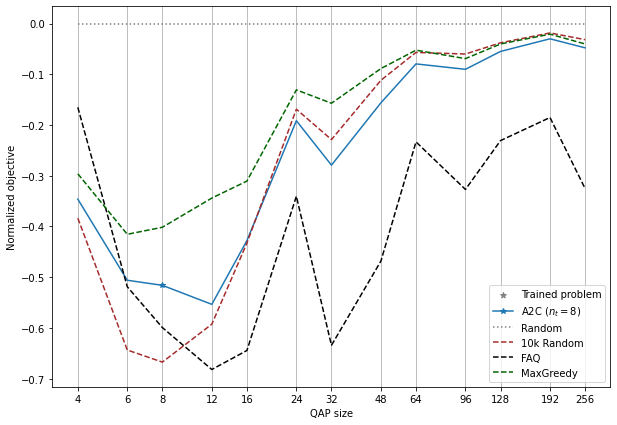

In [695]:
create_plot(["a2c_sm", "random", "rand10k", "faq", "max_greedy"], size=(10,7))

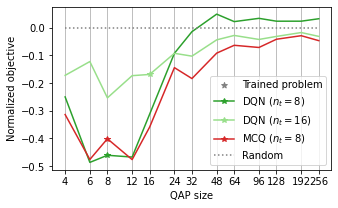

In [562]:
create_plot(["dqn_sm", "dqn_md", "mcq_sm", "random"])
plt.savefig(plot_path / "value_based.pdf", bbox_inches='tight')

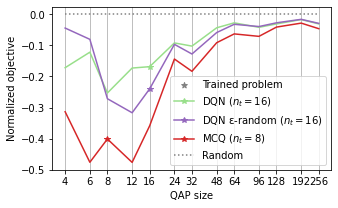

In [563]:
create_plot(["dqn_md", "dqn_md_e", "mcq_sm", "random"])
plt.savefig(plot_path / "dqn_epsilon.pdf", bbox_inches='tight')

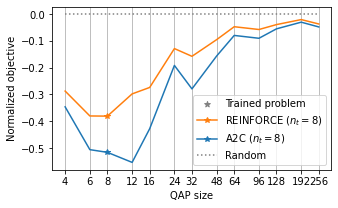

In [564]:
create_plot(["rf", "a2c_sm", "random"])
plt.savefig(plot_path / "a2c_vs_rf.pdf", bbox_inches='tight')

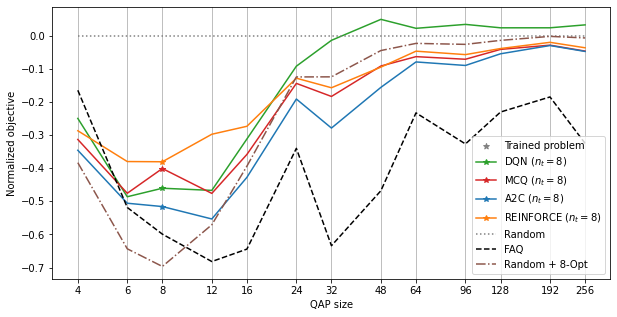

In [565]:
create_plot(["dqn_sm", "mcq_sm", "a2c_sm", "rf", "random", "faq", "last8opt"], size=(10,5))
plt.savefig(plot_path / "small_agents.pdf", bbox_inches='tight')

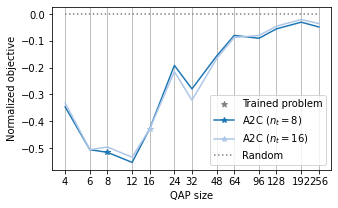

In [566]:
create_plot(["a2c_sm", "a2c_md", "random"])
plt.savefig(plot_path / "a2c_big_vs_small.pdf", bbox_inches='tight')

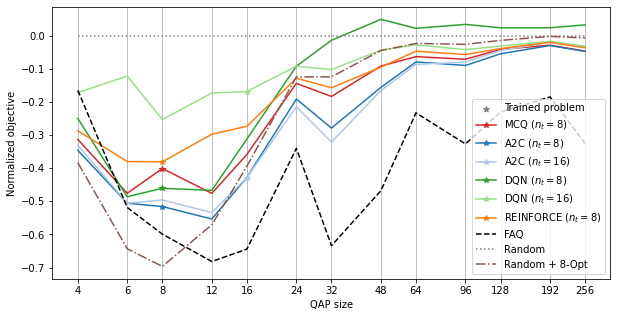

In [641]:
create_plot(["mcq_sm", "a2c_sm", "a2c_md", "dqn_sm", "dqn_md", "rf", "faq", "random", "last8opt"], size=(10,5))
plt.savefig(plot_path / "all.pdf", bbox_inches='tight')

[]

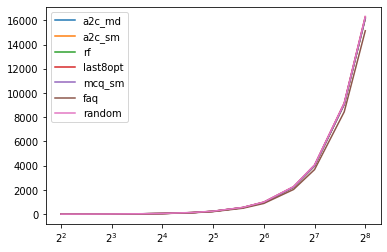

In [534]:
for s in ["a2c_md", "a2c_sm", "rf", "last8opt", "mcq_sm", "faq", "random"]:
    plt.plot(sizes, results[s]["means"], label=s)
plt.legend()
plt.semilogx(base=2)

[]

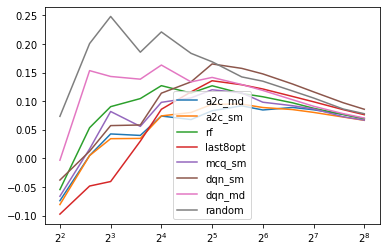

In [369]:
for s in ["a2c_md", "a2c_sm", "rf", "last8opt", "mcq_sm", "dqn_sm", "dqn_md", "random"]:
    base = results["faq"]["means"]
    plt.plot(sizes, results[s]["means"] / base - 1, label=s)
plt.legend()
plt.semilogx(base=2)

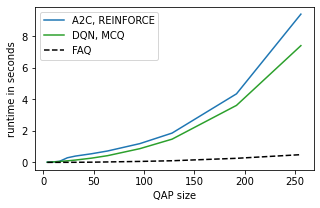

In [610]:
plt.figure(figsize=(5,3))
plt.plot(sizes, results["a2c_sm"]["times"], label="A2C, REINFORCE", color=plot_styles["a2c_sm"].color)
plt.plot(sizes, results["dqn_sm"]["times"], label="DQN, MCQ", color=plot_styles["dqn_sm"].color)
plt.plot(sizes, results["faq"]["times"], label="FAQ", color=plot_styles["faq"].color, linestyle=plot_styles["faq"].line_style)
plt.legend()
plt.xlabel("QAP size")
plt.ylabel("runtime in seconds")
plt.savefig(plot_path / "runtime.pdf", bbox_inches="tight")

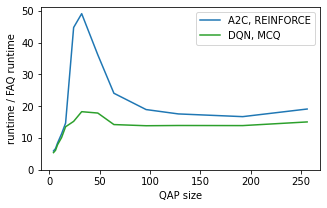

In [611]:
plt.figure(figsize=(5,3))
plt.plot(sizes, results["a2c_sm"]["times"]/results["faq"]["times"], label="A2C, REINFORCE", color=plot_styles["a2c_sm"].color)
plt.plot(sizes, results["dqn_sm"]["times"]/results["faq"]["times"], label="DQN, MCQ", color=plot_styles["dqn_sm"].color)
#plt.plot(sizes, results["faq"]["times"]/results["faq"]["times"], label="FAQ", color=plot_styles["faq"].color, linestyle=plot_styles["faq"].line_style)
plt.legend()
plt.ylim(ymin=0)
plt.xlabel("QAP size")
plt.ylabel("runtime / FAQ runtime")
plt.savefig(plot_path / "runtime_faq_factor.pdf", bbox_inches="tight")

#### plt.plot(sizes, results["rf"]["times"])

In [609]:
results["rf"]["times"] / results["random"]["times"]

array([  34.8635646 ,   66.08849639,   98.61863697,  174.39569693,
        207.62126258,  896.61601988, 1290.30151593, 1731.94831506,
        131.12973359, 2309.77760979, 2718.83000422, 5488.42624712,
       7275.88246324])

([<matplotlib.axis.XTick at 0x7f9d7ae8c730>,
 [Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(12, 0, '12'),
  Text(16, 0, '16'),
  Text(24, 0, '24')])

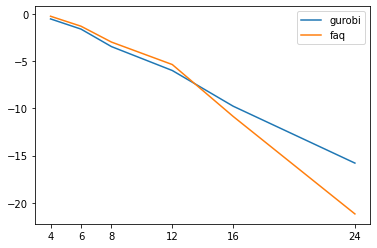

In [655]:
plt.plot(sizes[:6], results["gurobi_5s"]["means"] - results["random"]["means"][:6], label="gurobi")
plt.plot(sizes[:6], results["faq"]["means"][:6] - results["random"]["means"][:6], label="faq")
plt.legend()
plt.xticks(sizes[:6], labels=sizes[:6])

([<matplotlib.axis.XTick at 0x7f9d70907e50>,
 [Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(12, 0, '12'),
  Text(16, 0, '16'),
  Text(24, 0, '24')])

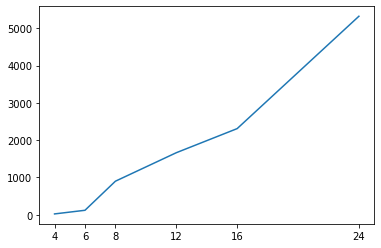

In [659]:
plt.plot(sizes[:6], results["gurobi_5s"]["times"] / results["faq"]["times"][:6])
plt.xticks(sizes[:6], labels=sizes[:6])

([<matplotlib.axis.XTick at 0x7f9db1644760>,
 [Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(12, 0, '12'),
  Text(16, 0, '16'),
  Text(24, 0, '24'),
  Text(32, 0, '32'),
  Text(48, 0, '48'),
  Text(64, 0, '64'),
  Text(96, 0, '96'),
  Text(128, 0, '128'),
  Text(192, 0, '192'),
  Text(256, 0, '256')])

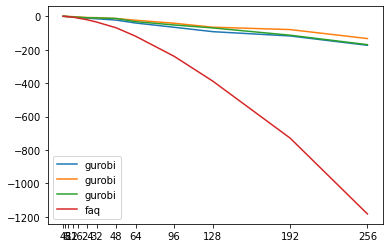

In [702]:
plt.plot(sizes, results["a2c_sm"]["means"] - results["random"]["means"], label="gurobi")
plt.plot(sizes, results["rf"]["means"] - results["random"]["means"], label="gurobi")
plt.plot(sizes, results["mcq_sm"]["means"] - results["random"]["means"], label="gurobi")
plt.plot(sizes, results["faq"]["means"] - results["random"]["means"], label="faq")
plt.legend()
plt.xticks(sizes, labels=sizes)